In [1]:
from model import *
from utils import *
from training import *

import importlib
import imports
importlib.reload(imports)
device = 'mps'

In [2]:
folder = os.getcwd()
filename = f'{folder}/ncmapps_ds02.csv'
print(filename)

/Users/alexei.ermochkine/Desktop/ma5/ML4PM/assignment_3_graded/ML4PM_assignment3/ncmapps_ds02.csv


In [3]:
df = pd.read_csv(filename)
df.head()

,T24,T30,T48,T50,P15,P2,P21,P24,Ps30,P40,...,Wf,alt,Mach,TRA,T2,RUL,Fc,unit,hs,cycle
0,593.28656,1422.0460,1797.2323,1214.0819,15.626362,11.445379,15.864327,19.897537,327.51962,332.79700,...,3.811431,9889.289,0.443401,76.022545,496.67758,74,3,2,1,1
1,593.30220,1422.3720,1797.9927,1214.1847,15.607640,11.424822,15.845321,19.881628,327.48330,332.75565,...,3.812693,9951.729,0.444472,76.222015,496.53890,74,3,2,1,1
2,593.14215,1421.8730,1797.1808,1213.5430,15.581609,11.407368,15.818893,19.848164,326.81784,332.08163,...,3.803472,10011.879,0.445830,76.191210,496.43396,74,3,2,1,1
3,592.98883,1421.4746,1796.5925,1213.0120,15.554759,11.387945,15.791634,19.814800,326.22076,331.47592,...,3.795554,10073.271,0.446986,76.196846,496.30667,74,3,2,1,1
4,592.66296,1420.8185,1795.7623,1212.4274,15.512026,11.356153,15.748249,19.760134,325.36660,330.60760,...,3.784542,10136.359,0.446471,76.204480,496.02774,74,3,2,1,1


In [4]:
LABELS = ['RUL']

Operative Conditions ($w$)

DASHlink- Flight Data For Tail 687.(2012). Retrieved on 2019-01-29 from https://c3.nasa.gov/dashlink/

In [5]:
W_VAR = ['alt', 'Mach', 'TRA', 'T2']

Sensor readings ($X_s$)

In [6]:
XS_VAR = ['T24', 'T30', 'T48', 'T50', 'P15', 'P2', 'P21', 'P24', 'Ps30', 'P40', 'P50', 'Nf', 'Nc', 'Wf']


In [ ]:
# dataset parameters
TRAIN_UNITS = [2, 5, 10, 16, 18, 20]
TEST_UNITS = [11, 14, 15]

DEFAULT_PARAMS = {
    # CNN model parameters
    'in_channels': 18, 
    'out_channels': 1,
    'window': 50, 
    'n_ch': 10, 
    'n_k': 10, 
    'n_hidden': 50, 
    'n_layers': 3,
    'dropout': 0.,
    'padding': 'same',
    # training parameters
    'batch_size': 512,  
    'base_lr': 1e-3,
    'weight_decay': 1e-5,
    'max_epochs': 50
}



DATASETS = create_datasets(df, window_size=DEFAULT_PARAMS['window'], train_units=TRAIN_UNITS, test_units=TEST_UNITS)
LOADERS = create_data_loaders(DATASETS, batch_size=DEFAULT_PARAMS['batch_size'], val_split=0.2)

train_size: 403236	validation_size: 100809	test_size: 115274


## Aggregate results of multiple runs

In [8]:
def run_single(seed, params=DEFAULT_PARAMS):
    seed_everything(seed)

    model = CNN(
        in_channels=params['in_channels'],
        out_channels=params['out_channels'], 
        n_ch=params['n_ch'],
        n_k=params['n_k'],
        n_hidden=params['n_hidden'],
        n_layers=params['n_layers'],
        dropout=params['dropout'],
    ).to(device)  # Move model to device immediately after creation

    optimizer = torch.optim.Adam(
        model.parameters(),
        lr=params['base_lr'],
        weight_decay=params['weight_decay'],
    )

    criterion = nn.MSELoss()
    trainer = Trainer(
        model,
        optimizer,
        criterion=criterion,
        n_epochs=params['max_epochs'],
        seed=seed,
        device=device  # Pass device to trainer
    )

    trainer.fit(LOADERS)
    df_eval, df_eval_out = trainer.eval_rul_prediction(LOADERS[1])
    df_test, df_test_out = trainer.eval_rul_prediction(LOADERS[2])
    return df_eval, df_eval_out, df_test, df_test_out

In [10]:
SEED = 42
seed_everything(SEED)
device = 'mps'
N_RUNS = 5
df_list = []  

for seed in range(SEED, SEED+N_RUNS):
    df_eval, df_eval_out, df_test, df_test_out = run_single(seed)
    df_list.append(df_test_out)  

df_all = pd.concat(df_list, ignore_index=True)  

Training model for 3 epochs...


/Users/alexei.ermochkine/Desktop/ma5/ML4PM/venv4ml4pm/lib/python3.12/site-packages/torch/nn/modules/conv.py:304: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/Convolution.cpp:1032.)
  return F.conv1d(input, weight, bias, self.stride,


[Epoch 1] train_loss = 264.47134, eval_loss = 205.88464, test_loss = 420.09033 [14.0s]
[Epoch 2] train_loss = 53.40139, eval_loss = 731.37335, test_loss = 1376.40454 [13.6s]


/Users/alexei.ermochkine/Desktop/ma5/ML4PM/assignment_3_graded/ML4PM_assignment3/training.py:187: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.l

[Epoch 3] train_loss = 50.94416, eval_loss = 48.67375, test_loss = 53.00978 [13.9s]
Task done in 41s
Evaluating test RUL...
Model CNN saved in models_baseline/best_model_baseline_1103112648.pt loaded to mps


100%|██████████| 99/99 [00:01<00:00, 53.58it/s]


Evaluating test RUL...
Model CNN saved in models_baseline/best_model_baseline_1103112648.pt loaded to mps


100%|██████████| 113/113 [00:01<00:00, 63.18it/s]


Training model for 3 epochs...
[Epoch 1] train_loss = 240.58371, eval_loss = 222.97217, test_loss = 180.40923 [13.5s]
[Epoch 2] train_loss = 56.17092, eval_loss = 223.97382, test_loss = 168.28877 [13.7s]
[Epoch 3] train_loss = 52.02872, eval_loss = 77.36838, test_loss = 169.79596 [13.4s]
Task done in 40s
Evaluating test RUL...
Model CNN saved in models_baseline/best_model_baseline_1103112733.pt loaded to mps


100%|██████████| 99/99 [00:01<00:00, 52.20it/s]


Evaluating test RUL...
Model CNN saved in models_baseline/best_model_baseline_1103112733.pt loaded to mps


100%|██████████| 113/113 [00:01<00:00, 62.17it/s]


Training model for 3 epochs...
[Epoch 1] train_loss = 250.24571, eval_loss = 72.60593, test_loss = 175.12018 [13.6s]
[Epoch 2] train_loss = 52.59269, eval_loss = 143.25771, test_loss = 131.71573 [14.4s]
[Epoch 3] train_loss = 49.58310, eval_loss = 128.49615, test_loss = 312.94199 [13.5s]
Task done in 41s
Evaluating test RUL...
Model CNN saved in models_baseline/best_model_baseline_1103112817.pt loaded to mps


100%|██████████| 99/99 [00:01<00:00, 52.12it/s]


Evaluating test RUL...
Model CNN saved in models_baseline/best_model_baseline_1103112817.pt loaded to mps


100%|██████████| 113/113 [00:01<00:00, 61.78it/s]


Training model for 3 epochs...
[Epoch 1] train_loss = 237.97797, eval_loss = 58.22810, test_loss = 108.21429 [13.5s]
[Epoch 2] train_loss = 57.23361, eval_loss = 129.29951, test_loss = 75.61677 [13.4s]
[Epoch 3] train_loss = 53.69719, eval_loss = 55.13306, test_loss = 80.76507 [13.2s]
Task done in 40s
Evaluating test RUL...
Model CNN saved in models_baseline/best_model_baseline_1103112903.pt loaded to mps


100%|██████████| 99/99 [00:01<00:00, 54.94it/s]


Evaluating test RUL...
Model CNN saved in models_baseline/best_model_baseline_1103112903.pt loaded to mps


100%|██████████| 113/113 [00:01<00:00, 64.85it/s]


Training model for 3 epochs...
[Epoch 1] train_loss = 287.11438, eval_loss = 120.26955, test_loss = 299.01245 [13.6s]
[Epoch 2] train_loss = 54.53247, eval_loss = 181.94070, test_loss = 414.80209 [13.5s]
[Epoch 3] train_loss = 49.71726, eval_loss = 70.71227, test_loss = 71.02855 [14.0s]
Task done in 41s
Evaluating test RUL...
Model CNN saved in models_baseline/best_model_baseline_1103112946.pt loaded to mps


100%|██████████| 99/99 [00:01<00:00, 53.22it/s]


Evaluating test RUL...
Model CNN saved in models_baseline/best_model_baseline_1103112946.pt loaded to mps


100%|██████████| 113/113 [00:02<00:00, 56.15it/s]


In [11]:
df_all.head()

,score,rmse,seed
0,1.860438,5.760322,42
1,3.465508,10.860218,43
2,3.460100,10.820140,44
3,2.112198,7.062218,45
4,1.720999,5.629219,46


# rest of code


In [ ]:
SEED = 42
seed_everything(SEED)
device = 'mps'

model = CNN(
  in_channels=DEFAULT_PARAMS['in_channels'],
  out_channels=DEFAULT_PARAMS['out_channels'],
  n_ch=DEFAULT_PARAMS['n_ch'],
  n_k=DEFAULT_PARAMS['n_k'],
  n_hidden=DEFAULT_PARAMS['n_hidden'],
  n_layers=DEFAULT_PARAMS['n_layers'],
  dropout=DEFAULT_PARAMS['dropout'],
).to(device)

print(model)

optimizer = torch.optim.Adam(
  model.parameters(),
  lr=DEFAULT_PARAMS['base_lr'],
  weight_decay=DEFAULT_PARAMS['weight_decay'],
)

criterion = nn.MSELoss()
trainer = Trainer(
  model,
  optimizer,
  criterion=criterion,
  n_epochs=DEFAULT_PARAMS['max_epochs'],
  seed=SEED,
  device=device
)

trainer.fit(LOADERS)

In [ ]:
# Evaluation code
print("Evaluating test RUL...")
model = trainer.model.to(device)  
df_test, df_out = trainer.eval_rul_prediction(LOADERS[-1])

In [10]:
trainer.plot_losses()

NameError: name 'trainer' is not defined

<Axes: >

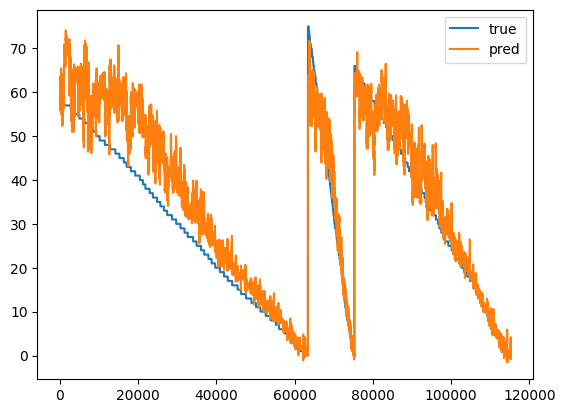

In [11]:
df_test.plot(y=['true', 'pred'])